In [1]:
import os
import wandb
import copy 
import json

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np



In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
import analyse_results_utils

In [4]:
colors = ["r","g","b","y","b","c"]

In [5]:
api = wandb.Api()
#sweep1 = api.sweep("adam_katona/uncategorized/w8g6k4rv") 
sweep1 = api.sweep("adam_katona/uncategorized/jum0205c") 
sweep2 = api.sweep("adam_katona/uncategorized/qxar7gjs") 
sweep3 = api.sweep("adam_katona/uncategorized/ya8fen9j") 
sweep_runs = list(sweep1.runs)
sweep_runs.extend(list(sweep2.runs))
sweep_runs.extend(list(sweep3.runs))

In [6]:
len(sweep_runs)

1648

In [7]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%100 == 0:
        print(i,"/",len(sweep_runs))
        
    #run_logs = wanddb_run.history()
        
    run_id = wanddb_run.dir.split("/")[-1]
    run_path = analyse_results_utils.id_to_path(run_id)
    run = {}
    run["path"] = analyse_results_utils.id_to_path(run_id)
    if  os.path.exists(run["path"]+"/b_archive.npy"):
        run["b_map_evolver"] = np.load(run["path"]+"/b_map_evolver.npy",allow_pickle=True)
        run["b_map_performance"] = np.load(run["path"]+"/b_map_performance.npy",allow_pickle=True)
        run["b_archive"] = np.load(run["path"]+"/b_archive.npy")
        run["wandb_run"] = wanddb_run
        run["config"] = wanddb_run.config
        all_runs.append(run)
    else:
        failed_runs.append(wanddb_run.config)
        

0 / 1648
100 / 1648
200 / 1648
300 / 1648
400 / 1648
500 / 1648


IndexError: list index out of range

In [ ]:
print("all_runs: ",len(all_runs))
print("failed_runs: ",len(failed_runs))

In [30]:
def config_to_type(config):
    # the types i am interested in are:
    # if the ubdates are combined, we put a "_C" at the end
    acceptable_names = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
    
    def in_mode(mode_list,mode):
        for m in mode_list:
            if mode in m:
                return True
        return False
    
    # first get the first part
    name = ""
    if config["BMAP_type_and_metrics"]["type"] == "single_map":
        if "eval_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "ME__"
        else:
            name += "E-ME-"
            if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "f"
            if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "e"
            if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "i"
            name += "__"
    else:    
        if config["BMAP_type_and_metrics"]["type"] == "multi_map":
            name += "MM-ME-"
        elif config["BMAP_type_and_metrics"]["type"] == "nd_sorted_map":
            name += "ND-ME-"
            
        if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "f"
        if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "e"
        if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "i"
        name += "__"
        
    # now get the second part
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"innovation"):
        name += "explore-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"evo"):
        name += "evolvability-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"fitness"):
        name += "exploit-"
        
    # remove trailing dash
    if name[-1] == "-":
        name = name[:-1]
    
    return name
    if name in acceptable_names:
        return name
    else:
        return "not_interested"
    
    
def group_runs_by_type(runs):
    typed_runs = {}
    for run in runs:
        run_type = config_to_type(run["config"])
        if run_type != "not_interested":
            if run_type in typed_runs:
                typed_runs[run_type].append(run)
            else:
                typed_runs[run_type] = [run]
    return typed_runs
            
    
type_runs = group_runs_by_type(all_runs)
    
    

In [35]:
acceptable_names = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-f__explore-evolvability-exploit",
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
    
    
a = list(type_runs.keys())
for n in a:
    if n in acceptable_names:
        print("YES  ",n,len(type_runs[n]))
    else:
        print("NO  ",n,len(type_runs[n]))
        
print("#########")
for n in acceptable_names:
    if n in a:
        print("YES  ",n)
    else:
        print("NO  ",n)

NO   E-ME-f__explore 32
YES   E-ME-f__evolvability 34
YES   E-ME-f__exploit 17
NO   ME__explore-evolvability 34
YES   ME__explore 68
NO   ME__evolvability 68
YES   ME__exploit 34
YES   MM-ME-fei__explore-evolvability-exploit 18
NO   MM-ME-fei__explore 34
NO   MM-ME-fei__evolvability 34
NO   MM-ME-fei__exploit 34
NO   MM-ME-fei__explore-evolvability 17
NO   MM-ME-fi__explore-evolvability 34
NO   MM-ME-fi__explore-evolvability-exploit 34
NO   MM-ME-fi__explore 34
NO   MM-ME-fi__evolvability 34
NO   MM-ME-fi__exploit 34
NO   MM-ME-fe__explore-evolvability 34
NO   MM-ME-fe__explore-evolvability-exploit 34
NO   MM-ME-fe__explore 34
NO   MM-ME-fe__evolvability 34
NO   MM-ME-fe__exploit 34
YES   ND-ME-fei__explore-evolvability-exploit 30
NO   ND-ME-fei__explore 34
NO   ND-ME-fei__evolvability 34
NO   ND-ME-fei__exploit 34
NO   ND-ME-fei__explore-evolvability 17
NO   ND-ME-fi__explore-evolvability 34
NO   ND-ME-fi__explore-evolvability-exploit 34
NO   ND-ME-fi__explore 34
NO   ND-ME-fi__evolva

In [12]:
def group_runs_by_selection_type(runs):
    grouped_runs = {}
    for run in runs:
        run_conf = copy.deepcopy(run["config"])
        mode = run_conf["ES_PARENT_SELECTION_MODE"]
        run_conf["ES_PARENT_SELECTION_MODE"] = 0
        run_conf = json.dumps(run_conf)
        if run_conf in grouped_runs:
            grouped_runs[run_conf][mode] = run
        else:
            grouped_runs[run_conf] = {mode : run}
    return grouped_runs

grouped_runs = group_runs_by_selection_type(all_runs)

non_empty_ratio
139


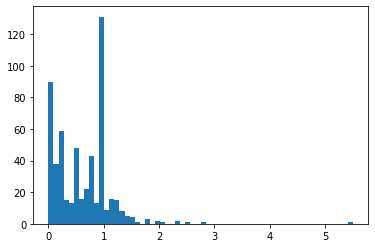

normal_qd_score
278


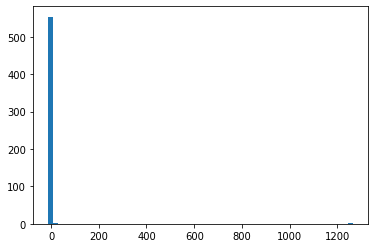

distance_qd_score
417


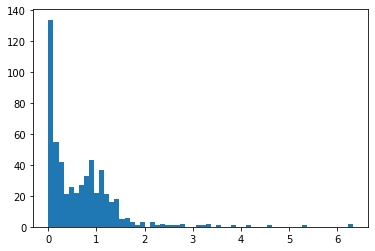

best_normal_fitness
556


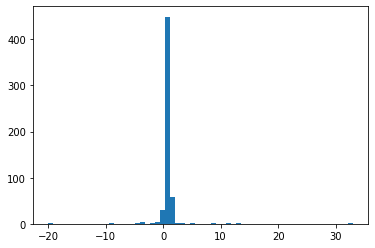

best_distance_fitness
695


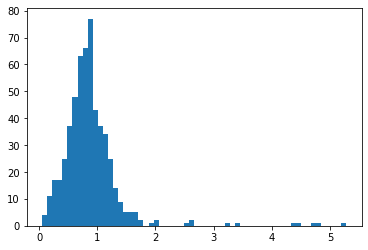

In [18]:
# calculate the ratios if ranked to uniform
metrics = ["non_empty_ratio","normal_qd_score","distance_qd_score","best_normal_fitness","best_distance_fitness"]

num_failed = 0
for m in metrics:
    print(m)
    ratios = []
    types = ["single_map","multi_map","nd_sorted_map"]
    for map_type in types:
        selected_runs = [for run in runs]
    select_where_keys_are(runs,keys,key_values)
    for conf,runs in grouped_runs.items():
        if "rank_proportional" in runs and "uniform" in runs:
            ratios.append(runs["rank_proportional"][m] / runs["uniform"][m])
        else:
            num_failed += 1
    
    print(num_failed)
    plt.hist(ratios,bins=60)
    plt.show()

    

  

In [11]:
#print(all_runs[0].keys())
#print(all_runs[0]["run_logs"].keys())

dict_keys(['wandb_run', 'run_logs', 'config', 'path', 'b_map_evolver', 'b_map_performance', 'b_archive'])
Index(['perf_qd_normal_fitness', 'max_control_cost', 'mean_control_cost',
       'innovation', 'perf_qd_mean_dist', '_step', 'eval_control_cost',
       'perf_qd_control_cost', 'evo_ent', '_runtime', 'eval_mean_dist',
       'excpected_fitness', 'perf_qd_score', 'eval_normal_fitness',
       'mean_dist', 'mean_normal_fitness', 'evaluations_so_far',
       'generation_number', 'max_dist', 'evo_var', 'perf_nonempty_ratio',
       '_timestamp'],
      dtype='object')


In [ ]:
# plot the fitness frequency curves
# for this i nned to get the fitness vector in the maps


In [13]:
type(all_runs[0]["b_map_performance"])

numpy.ndarray

In [19]:
elites = all_runs[0]["b_map_performance"][all_runs[0]["b_map_performance"] != None]

In [22]:
elites[0]["elite"].keys()

dict_keys(['ID', 'parent_ID', 'generation_created', 'params', 'child_eval', 'eval_fitness', 'eval_bc', 'excpected_fitness', 'innovation', 'evo_var', 'evo_ent', 'eval_mean_dist', 'eval_normal_fitness', 'eval_control_cost'])

In [25]:


grouped_runs = group_by_keys(all_runs,["env_name","env_mode"])
# sort
grouped_runs = {k: grouped_runs[k] for k in sorted(grouped_runs,key=lambda x: x[0])}
grouped_runs = {k: group_runs_with_same_conf(grouped_runs[k]) for k in grouped_runs}


In [26]:
for a,b in grouped_runs.items():
    print(a,len(b))

('ant', 'NORMAL_CONTACT') 11
('ant', 'CONTROL_FINAL_POS') 11
('ant', 'NORMAL_FINAL_POS') 11
('ant', 'DISTANCE_CONTACT') 11
('ant', 'DISTANCE_FINAL_POS') 11
('ant', 'DIRECTIONAL_CONTACT') 10
('humanoid', 'NORMAL_FINAL_POS') 11
('humanoid', 'CONTROL_FINAL_POS') 11
('humanoid', 'DIRECTIONAL_CONTACT') 10
('humanoid', 'DISTANCE_CONTACT') 11
('humanoid', 'DISTANCE_FINAL_POS') 11
('humanoid', 'NORMAL_CONTACT') 11
('walker', 'NORMAL_CONTACT') 11
('walker', 'CONTROL_FINAL_POS') 11
('walker', 'NORMAL_FINAL_POS') 11
('walker', 'DISTANCE_CONTACT') 11
('walker', 'DISTANCE_FINAL_POS') 11


In [13]:
# things i might want to plot, print
# I should put these in a dataframe
# - non-empyt ratio
# - qd-score (normal fitness)
# - qd-score (distance walked)
# - evolvability
# - best_eval-normal-fitness 
# - best_eval-distance-walked 

# I should also have decriptor fields
# - env name
# - env mode
# - evo map type
# - evo map metrics

def add_colums_with_key(df,column_name,runs,lambda_fun):
    df[column_name] = [lambda_fun(run) for run in runs]

def get_non_empty_ratio(run):
    num_cells = run["b_map_performance"].size
    num_nonempty = sum((run["b_map_performance"] != None).reshape(-1))
    val = float(num_nonempty)/num_cells
    run["non_empty_ratio"] = val
    return val
    
def get_normal_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_normal_fitness"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["normal_qd_score"] = val
    return val


def get_distance_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_mean_dist"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["distance_qd_score"] = val
    return val

def get_best_normal_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_normal_fitness"] for cell in non_empty])
    run["best_normal_fitness"] = val
    return val
    
def get_best_distance_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_mean_dist"] for cell in non_empty])
    run["best_distance_fitness"] = val
    return val
    
import pandas as pd
df = pd.DataFrame()
add_colums_with_key(df,"env_name",all_runs,lambda x : x["config"]["env_name"])
add_colums_with_key(df,"env_mode",all_runs,lambda x : x["config"]["env_mode"])
add_colums_with_key(df,"map_type",all_runs,lambda x : x["config"]["BMAP_type_and_metrics"]["type"])
add_colums_with_key(df,"map_metrics",all_runs,lambda x : "".join(x["config"]["BMAP_type_and_metrics"]["metrics"]))
add_colums_with_key(df,"updates",all_runs,lambda x : "".join(x["config"]["ES_UPDATES_MODES_TO_USE"]))

add_colums_with_key(df,"non_empty_ratio",all_runs,get_non_empty_ratio)
add_colums_with_key(df,"normal_qd_score",all_runs,get_normal_qd_score)
add_colums_with_key(df,"distance_qd_score",all_runs,get_distance_qd_score)
add_colums_with_key(df,"best_normal_fitness",all_runs,get_best_normal_fitness)
add_colums_with_key(df,"best_distance_fitness",all_runs,get_best_distance_fitness)

df

,env_name,env_mode,map_type,map_metrics,updates,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
0,walker,CONTROL_FINAL_POS,single_map,excpected_fitness,quality_innovation,0.040000,496.436024,4.057260,163.45547,1.1654207
1,humanoid,CONTROL_FINAL_POS,single_map,excpected_fitness,quality_innovation,0.002930,818.550583,1.676540,427.76093,1.1937994
2,ant,CONTROL_FINAL_POS,single_map,excpected_fitness,quality_innovation,0.003906,666.695503,3.092183,216.78711,1.1301852
3,walker,DISTANCE_FINAL_POS,single_map,excpected_fitness,quality_innovation,0.040000,399.915127,4.422717,178.67253,1.2150847
4,humanoid,DISTANCE_FINAL_POS,single_map,excpected_fitness,quality_innovation,0.003906,1028.019035,2.211933,417.16968,0.901648
...,...,...,...,...,...,...,...,...,...,...
1248,humanoid,NORMAL_FINAL_POS,nd_sorted_map,excpected_fitnessevo_ent,fitness,0.003906,2146.736267,2.959814,573.65424,0.7735416
1249,ant,NORMAL_FINAL_POS,nd_sorted_map,excpected_fitnessevo_ent,fitness,0.003906,840.810837,1.376898,228.42331,0.37066668
1250,walker,NORMAL_CONTACT,nd_sorted_map,excpected_fitnessevo_ent,fitness,0.208008,19686.559561,186.270413,181.6804,1.425165
1251,humanoid,NORMAL_CONTACT,nd_sorted_map,excpected_fitnessevo_ent,fitness,0.303711,81889.887344,140.448672,452.91736,0.9434033


In [13]:
df.shape

(755, 9)

In [14]:
df.to_csv("es_map_results.csv")

In [37]:
# we wanto to have a bunch of tables
# for each env and env mode we want to compare all algos with each other in all metrics
g = df.groupby(by=["env_name","env_mode"])



In [28]:
for keys,val in g.groups.items():
    print(keys)
    #print(df.loc[val])

('ant', 'CONTROL_FINAL_POS')
('ant', 'DIRECTIONAL_CONTACT')
('ant', 'DISTANCE_CONTACT')
('ant', 'DISTANCE_FINAL_POS')
('ant', 'NORMAL_CONTACT')
('ant', 'NORMAL_FINAL_POS')
('humanoid', 'CONTROL_FINAL_POS')
('humanoid', 'DIRECTIONAL_CONTACT')
('humanoid', 'DISTANCE_CONTACT')
('humanoid', 'DISTANCE_FINAL_POS')
('humanoid', 'NORMAL_CONTACT')
('humanoid', 'NORMAL_FINAL_POS')
('walker', 'CONTROL_FINAL_POS')
('walker', 'DISTANCE_CONTACT')
('walker', 'DISTANCE_FINAL_POS')
('walker', 'NORMAL_CONTACT')
('walker', 'NORMAL_FINAL_POS')


In [42]:
#df.loc[g.groups[('ant', 'NORMAL_CONTACT')]]
#df.loc[g.groups[('ant', 'DISTANCE_FINAL_POS')]]
#df.loc[g.groups[('ant', 'DISTANCE_CONTACT')]]
df.loc[g.groups[('walker', 'DISTANCE_CONTACT')]]



,env_name,env_mode,map_type,map_metrics,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
6,walker,DISTANCE_CONTACT,single_map,quality_innovation,0.231445,5244.531764,185.461791,61.428844,1.3336841
23,walker,DISTANCE_CONTACT,single_map,quality_evo_ent,0.293945,16590.811936,258.921750,213.18272,1.8107214
40,walker,DISTANCE_CONTACT,single_map,innovation,0.324219,10039.694208,223.923069,136.06674,1.4629028
57,walker,DISTANCE_CONTACT,single_map,evo_ent,0.342773,15245.167223,198.363598,132.3026,1.2899622
74,walker,DISTANCE_CONTACT,single_map,fitness,0.253906,11012.278528,218.420251,139.95956,1.7562469
91,walker,DISTANCE_CONTACT,single_map,quality_evo_ent_innovation,0.171875,14038.069681,156.025154,136.24477,1.3262563
108,walker,DISTANCE_CONTACT,single_map,quality_innovation,0.178711,5273.893546,168.576686,119.57869,1.4082081
125,walker,DISTANCE_CONTACT,single_map,quality_evo_ent,0.313477,12593.996016,211.541292,117.40133,1.5043712
142,walker,DISTANCE_CONTACT,single_map,innovation,0.239258,8023.989726,138.342774,128.27647,1.1478323
159,walker,DISTANCE_CONTACT,single_map,evo_ent,0.092773,8066.522470,105.672507,133.10846,1.4959393


In [50]:
g = df.groupby(by="env_name")
df.loc[g.groups['ant']].sort_values("non_empty_ratio",ascending=False)

,env_name,env_mode,map_type,map_metrics,updates,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
161,ant,DISTANCE_CONTACT,single_map,eval_fitness,evo_ent,0.040895,-5473.870066,94.393079,208.96318,3.6514838
444,ant,DISTANCE_CONTACT,multi_map,excpected_fitnessevo_ent,evo_ent,0.038580,-2130.150433,62.718394,211.88913,3.725851
14,ant,NORMAL_CONTACT,single_map,eval_fitness,quality_innovation,0.038580,-307.262145,78.391534,223.07526,2.9435527
595,ant,DISTANCE_CONTACT,nd_sorted_map,excpected_fitnessevo_ent,quality_evo_ent_innovation,0.038580,-4167.808120,129.292603,236.40898,4.396432
703,ant,NORMAL_CONTACT,nd_sorted_map,excpected_fitnessevo_ent,fitnessevo_entinnovation,0.035494,-2369.353950,70.710275,182.25484,3.3741553
...,...,...,...,...,...,...,...,...,...,...
513,ant,NORMAL_FINAL_POS,nd_sorted_map,excpected_fitnessinnovation,quality_evo_ent_innovation,0.000977,236.098282,2.188554,236.09828,2.1885538
237,ant,DISTANCE_FINAL_POS,multi_map,excpected_fitnessinnovation,fitnessevo_entinnovation,0.000977,145.601974,1.698718,145.60197,1.6987182
564,ant,NORMAL_FINAL_POS,nd_sorted_map,excpected_fitnessinnovation,evo_ent,0.000977,221.909332,1.115211,221.90933,1.1152114
575,ant,DISTANCE_FINAL_POS,nd_sorted_map,excpected_fitnessinnovation,fitness,0.000977,-230.985153,3.066355,-230.98515,3.0663552


In [55]:
columns = ["non_empty_ratio","normal_qd_score","distance_qd_score","best_normal_fitness","best_distance_fitness"]
a = df[columns]#.loc(0).values
a.loc[2].values

array([0.00390625, 867.3672027587891, 1.550033450126648,
       array(221.80798, dtype=float32), array(0.4450203, dtype=float32)],
      dtype=object)

In [43]:
# let us do a radarplot
import plotly.express as px

columns = ["non_empty_ratio","normal_qd_score","distance_qd_score","best_normal_fitness","best_distance_fitness"]

fig = px.line_polar(
                    r=avg_iris.loc[0].values,
                    theta=columns,
                    line_close=True,
                    range_r = [0,1.0],
                    title="IRIS - %s"%iris.target_names[0])


fig.show()

#################  eval_normal_fitness
('ant', 'NORMAL_CONTACT')


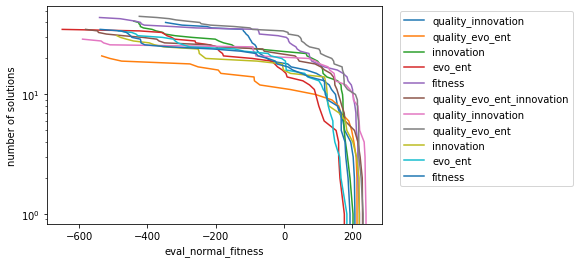

('ant', 'CONTROL_FINAL_POS')


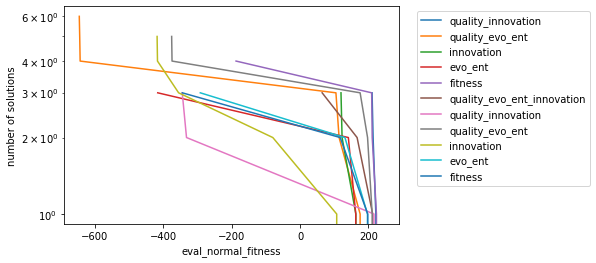

('ant', 'NORMAL_FINAL_POS')


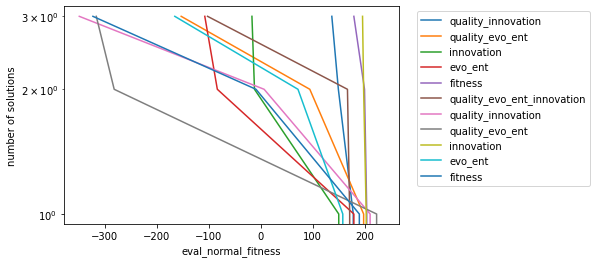

('ant', 'DISTANCE_CONTACT')


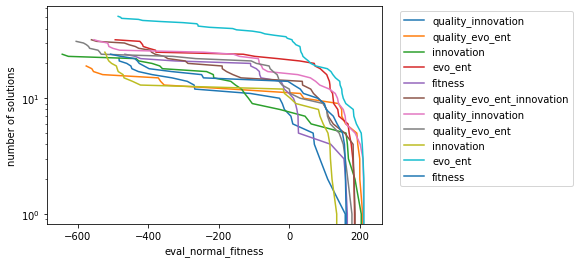

('ant', 'DISTANCE_FINAL_POS')


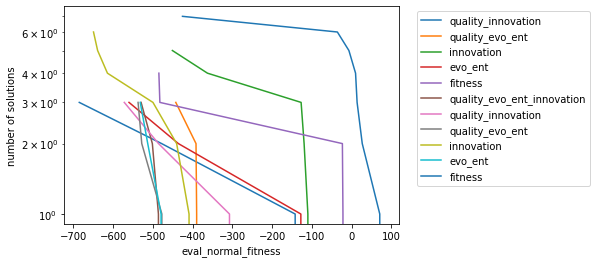

('ant', 'DIRECTIONAL_CONTACT')


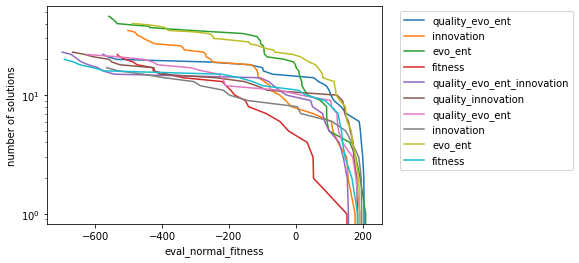

('humanoid', 'NORMAL_FINAL_POS')


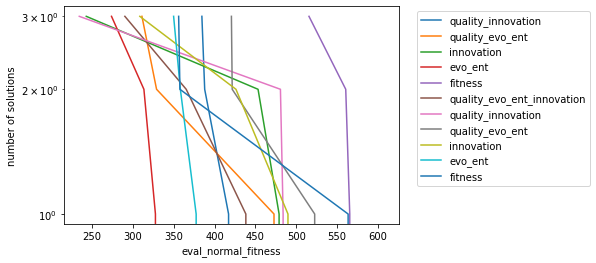

('humanoid', 'CONTROL_FINAL_POS')


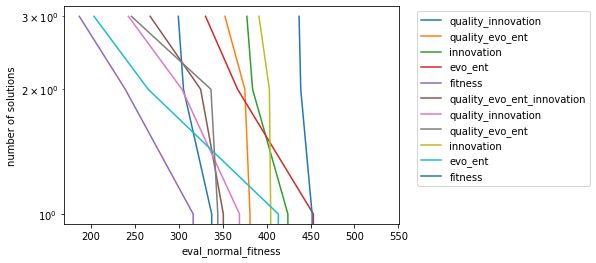

('humanoid', 'DIRECTIONAL_CONTACT')


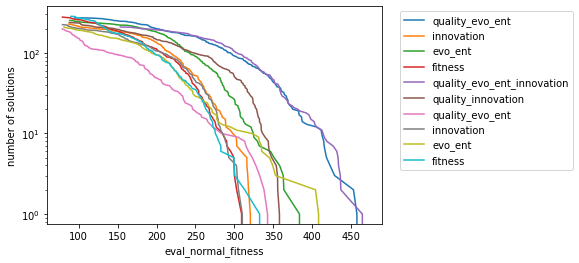

('humanoid', 'DISTANCE_CONTACT')


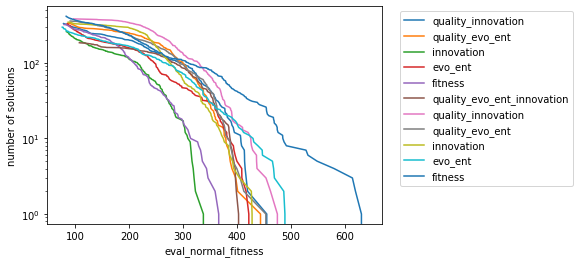

('humanoid', 'DISTANCE_FINAL_POS')


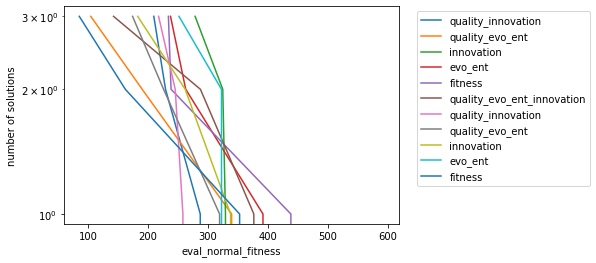

('humanoid', 'NORMAL_CONTACT')


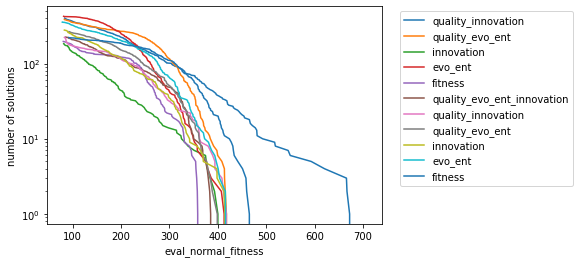

('walker', 'NORMAL_CONTACT')


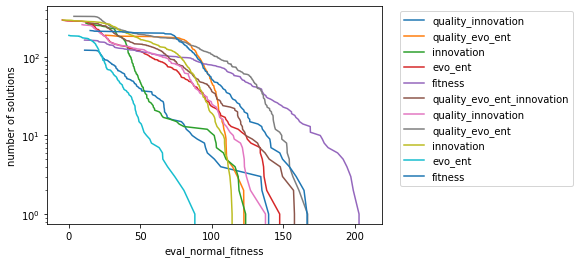

('walker', 'CONTROL_FINAL_POS')


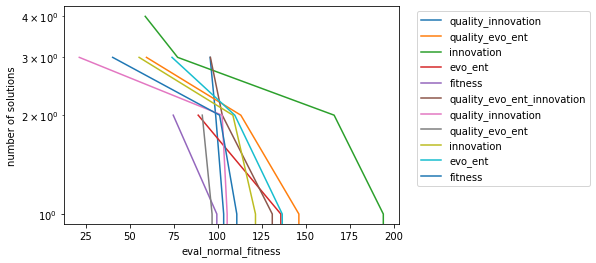

('walker', 'NORMAL_FINAL_POS')


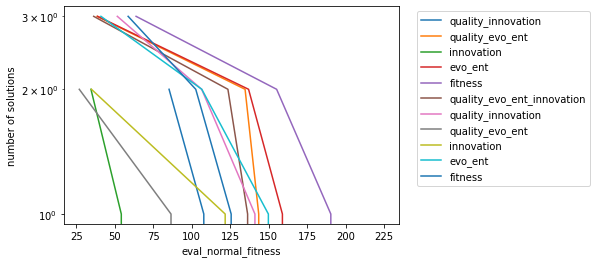

('walker', 'DISTANCE_CONTACT')


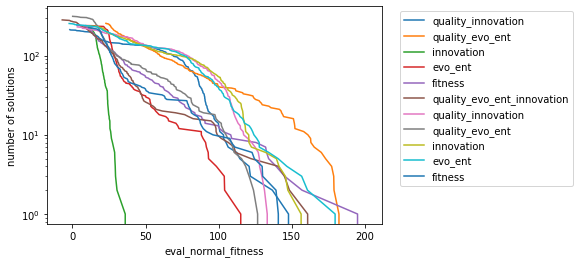

('walker', 'DISTANCE_FINAL_POS')


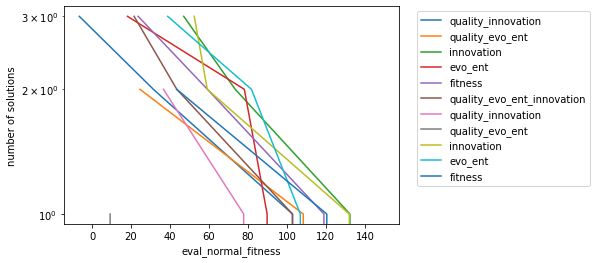

#################  eval_mean_dist
('ant', 'NORMAL_CONTACT')


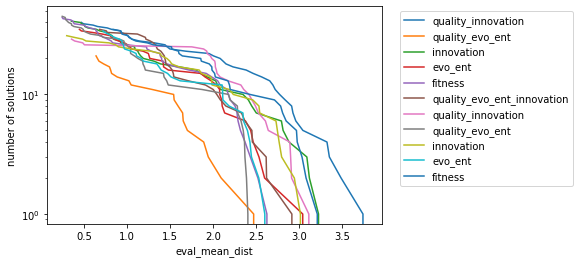

('ant', 'CONTROL_FINAL_POS')


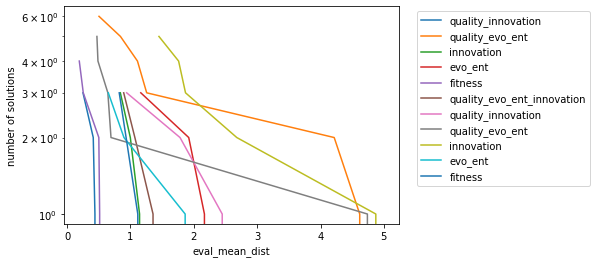

('ant', 'NORMAL_FINAL_POS')


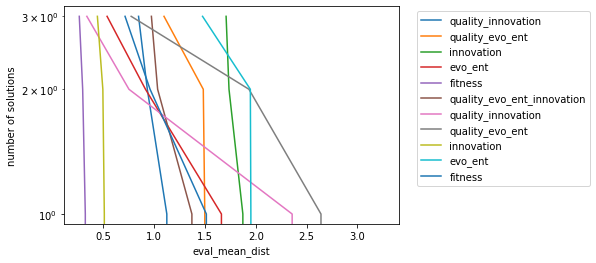

('ant', 'DISTANCE_CONTACT')


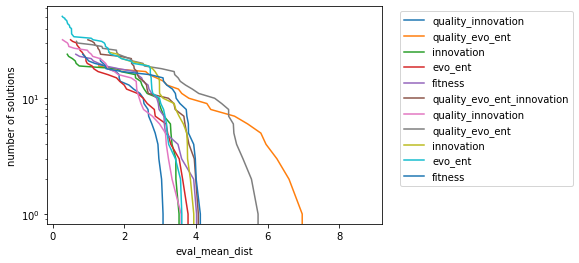

('ant', 'DISTANCE_FINAL_POS')


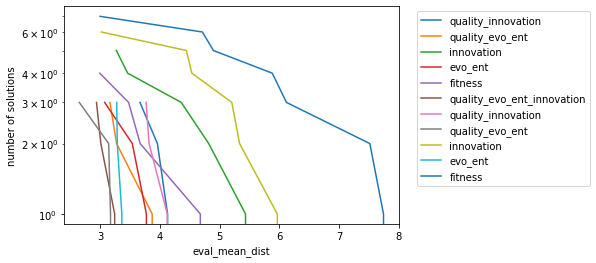

('ant', 'DIRECTIONAL_CONTACT')


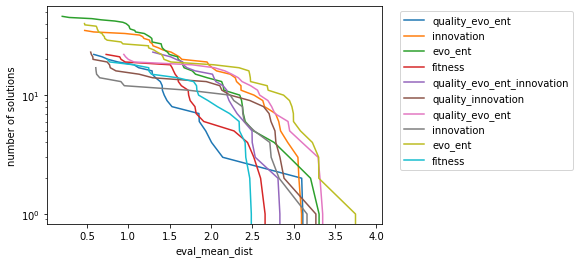

('humanoid', 'NORMAL_FINAL_POS')


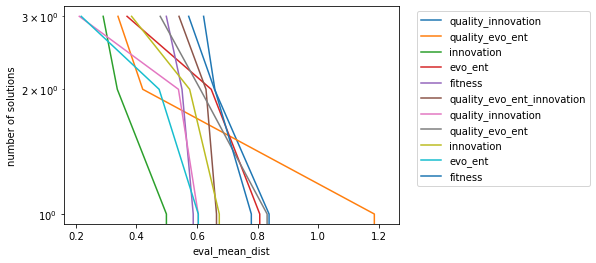

('humanoid', 'CONTROL_FINAL_POS')


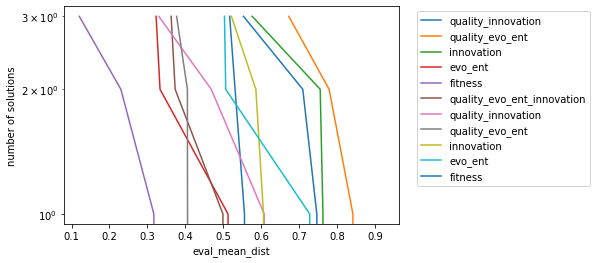

('humanoid', 'DIRECTIONAL_CONTACT')


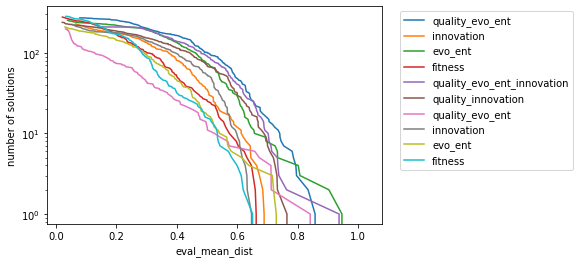

('humanoid', 'DISTANCE_CONTACT')


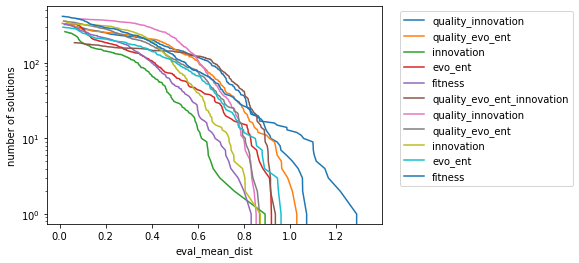

('humanoid', 'DISTANCE_FINAL_POS')


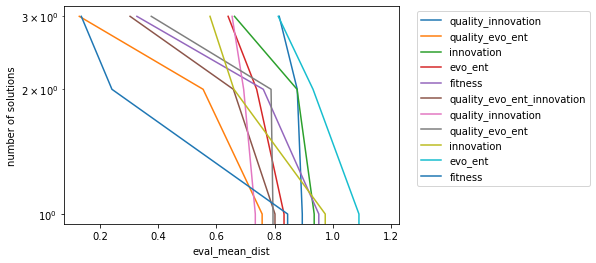

('humanoid', 'NORMAL_CONTACT')


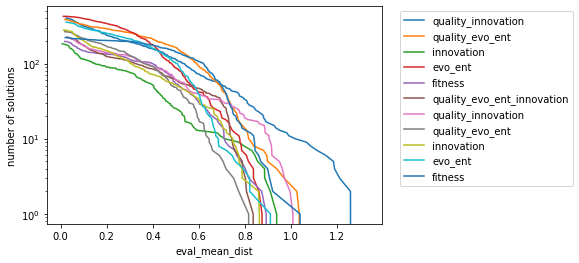

('walker', 'NORMAL_CONTACT')


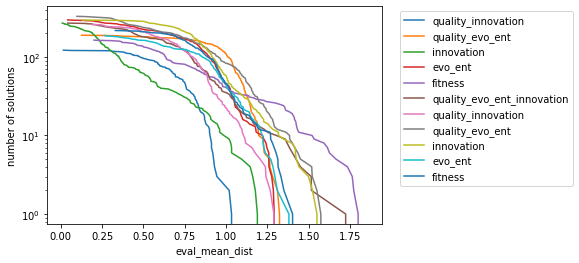

('walker', 'CONTROL_FINAL_POS')


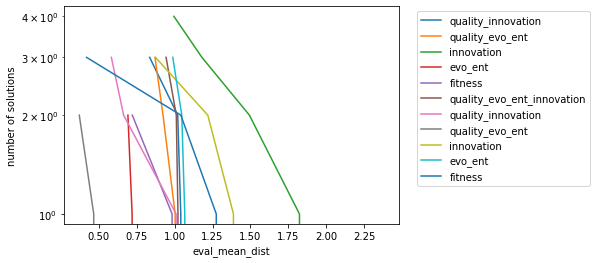

('walker', 'NORMAL_FINAL_POS')


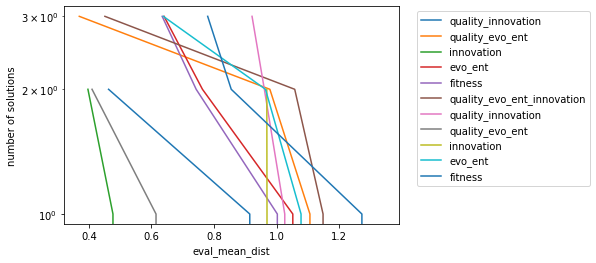

('walker', 'DISTANCE_CONTACT')


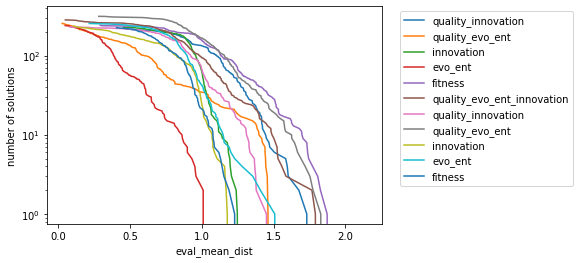

('walker', 'DISTANCE_FINAL_POS')


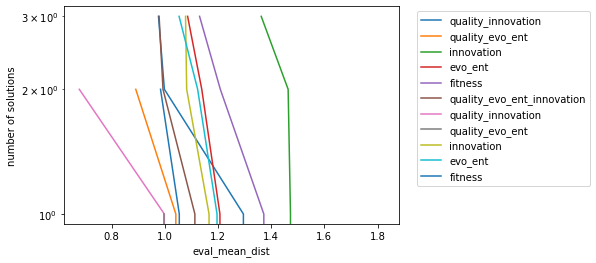

In [30]:
metrics_to_plot = ["eval_normal_fitness","eval_mean_dist"]

for metric in metrics_to_plot:
    print("################# ",metric)
    for env_tuple,runs_dict in grouped_runs.items():
        print(env_tuple)
        labels = []
        for run_list in runs_dict.values():
            for run in run_list:  
                
                elites = run["b_map_performance"][run["b_map_performance"] != None]
                metric_vec_list = sorted([elite["elite"][metric] for elite in elites])
                plt.plot(metric_vec_list[::-1],range(len(metric_vec_list)))
                labels.append("".join(str(mode) for mode in run_list[0]["config"]["ES_UPDATES_MODES_TO_USE"]))
            
        plt.legend(labels,bbox_to_anchor=(1.04,1))
        plt.yscale("log")
        plt.xlabel(metric)
        plt.ylabel("number of solutions")
        plt.show()

In [19]:
a = [3,4]

In [20]:
a

[3, 4]

In [22]:
a = "dfsf-"
if a[-1] == "-":
    a = a[:-1]
a

'dfsf'